## Import packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

%matplotlib inline

## Helper functions

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [4]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32):    #(0, 1)for mping.imread() of png files
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Train the model

### Check some images from datasets

Reading in data...
Vehicle: 8792
Non-Vehicle: 8968


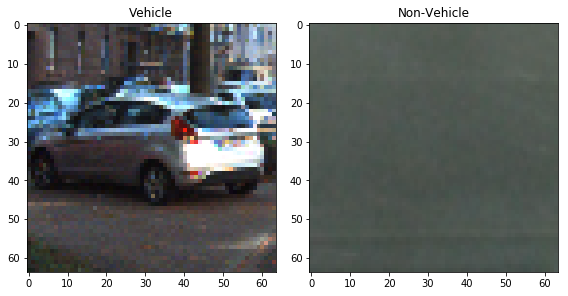

In [6]:
# Read in cars and notcars
cars = glob.glob('dataset/vehicles/*/*.png')
notcars = glob.glob('dataset/non-vehicles/*/*.png')
print('Reading in data...')
print('Vehicle:', len(cars))
print('Non-Vehicle:', len(notcars))

# Random image from each class
i = np.random.randint(0, len(cars))
car_img = mpimg.imread(cars[i])
notcar_img = mpimg.imread(notcars[i])

fig = plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(car_img)
plt.title('Vehicle')
plt.subplot(122)
plt.imshow(notcar_img)
plt.title('Non-Vehicle')
fig.tight_layout()

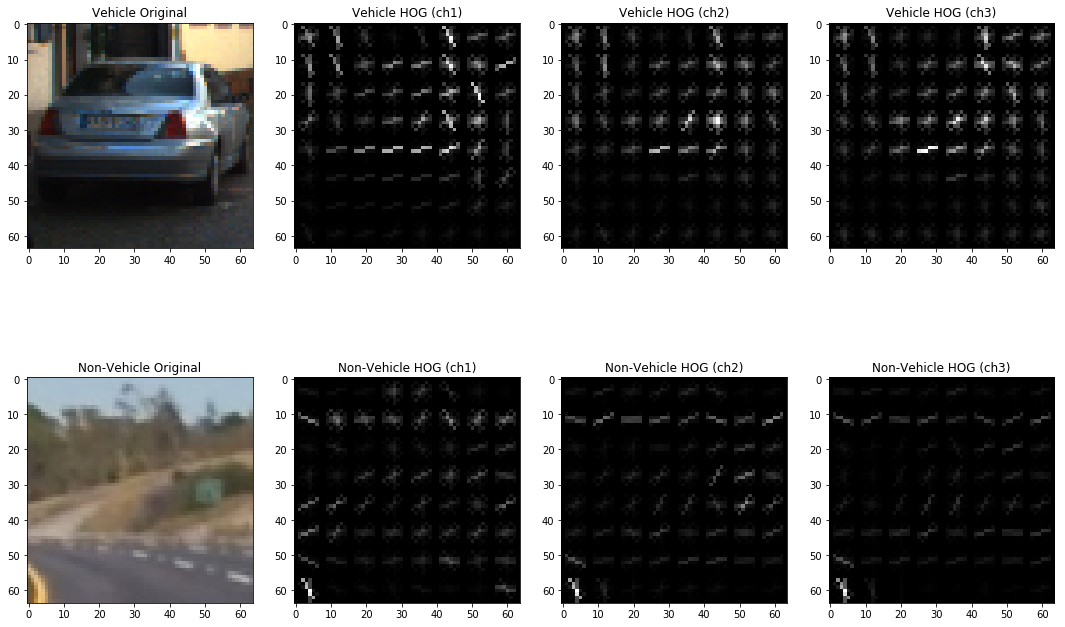

In [7]:
# HOG feature output
i = np.random.randint(0, len(cars))
car_img = mpimg.imread(cars[i])
notcar_img = mpimg.imread(notcars[i])

# HOG parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

hog_imgs = []
for img in [car_img, notcar_img]:    
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    feature1, hog_img1 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    feature2, hog_img2 = get_hog_features(feature_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    feature3, hog_img3 = get_hog_features(feature_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    hog_imgs.append((hog_img1,hog_img2,hog_img3))

fig, ax = plt.subplots(2, 4, figsize=(15, 10))
fig.tight_layout()    

ax[0][0].set_title('Vehicle Original')
ax[0][0].imshow(car_img)
for j in range(3):
    ax[0][j+1].set_title('Vehicle HOG (ch%d)' % (j+1))
    ax[0][j+1].imshow(hog_imgs[0][j], cmap='gray')
    
ax[1][0].set_title('Non-Vehicle Original')
ax[1][0].imshow(notcar_img)
for j in range(3):
    ax[1][j+1].set_title('Non-Vehicle HOG (ch%d)' % (j+1))
    ax[1][j+1].imshow(hog_imgs[1][j], cmap='gray')

In [8]:
import pickle

try:
    # Load a pe-trained svc model from a pickle file    
    dist_pickle = pickle.load(open('svc_model.p', 'rb'))
    print('Loading saved model...')

    # get attributes of our svc object
    svc = dist_pickle['svc']
    X_test = dist_pickle['X_test']
    y_test = dist_pickle['y_test']
    X_scaler = dist_pickle['scaler']
    color_space = dist_pickle['color_space']
    orient = dist_pickle['orient']
    pix_per_cell = dist_pickle['pix_per_cell']
    cell_per_block = dist_pickle['cell_per_block']
    hog_channel = dist_pickle['hog_channel']
    spatial_size = dist_pickle['spatial_size']
    hist_bins = dist_pickle['hist_bins']   
    spatial_feat = dist_pickle['spatial_feat']
    hist_feat = dist_pickle['hist_feat']
    hog_feat = dist_pickle['hog_feat']
        
    # Some model infos
    print('Model attributes:')
    print('orient:', orient)
    print('pix_per_cell:', pix_per_cell)
    print('cell_per_block:', cell_per_block)
    print('spatial_size:', spatial_size)
    print('hist_bins:', hist_bins)
    print('Feature vector length:', len(X_test[0]))
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
except:
    print('No pre-trained model found!')
    # Parameters to tweak    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    
    # Some model infos
    print('Model attributes:')
    print('orient:', orient)
    print('pix_per_cell:', pix_per_cell)
    print('cell_per_block:', cell_per_block)
    print('spatial_size:', spatial_size)
    print('hist_bins:', hist_bins)

    # Read in cars and notcars
    cars = glob.glob('dataset/vehicles/*/*.png')
    notcars = glob.glob('dataset/non-vehicles/*/*.png')
    print('Reading in data')

    # Calculate feature
    print('Calculating features...')
    t=time.time()
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print('Took', round(t2-t, 2), 'seconds to calculate features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        
    # Save trained results to pickle    
    dist_pickle = {}
    dist_pickle['X_test'] = X_test
    dist_pickle['y_test'] = y_test
    dist_pickle['svc'] = svc
    dist_pickle['scaler'] = X_scaler
    dist_pickle['orient'] = orient
    dist_pickle['pix_per_cell'] =  pix_per_cell
    dist_pickle['cell_per_block'] = cell_per_block
    dist_pickle['spatial_size'] = spatial_size
    dist_pickle['hist_bins'] = hist_bins
    dist_pickle['color_space'] = color_space    
    dist_pickle['hog_channel'] = hog_channel    
    dist_pickle['spatial_feat'] = spatial_feat
    dist_pickle['hist_feat'] = hist_feat
    dist_pickle['hog_feat'] = hog_feat
    
    print('Saving pickle...')
    pickle.dump(dist_pickle, open('svc_model.p', 'wb'))
    print('Done.')

Loading saved model...
Model attributes:
orient: 9
pix_per_cell: 8
cell_per_block: 2
spatial_size: (32, 32)
hist_bins: 32
Feature vector length: 8460
Test Accuracy of SVC =  0.9873


## Predict test image

In [9]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)    

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space='RGB', hog_channel=0, vis=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    if color_space != 'RGB':
            if color_space == 'HSV':
                ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')
            elif color_space == 'LUV':
                ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')
            elif color_space == 'HLS':
                ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HLS')
            elif color_space == 'YUV':
                ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
            elif color_space == 'YCrCb':
                ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    else:
        ctrans_tosearch = np.copy(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]
    
   # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Initiate empty list for boundary boxes
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))       
            else:
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)            
            hist_features = color_hist(subimg, nbins=hist_bins)            

            # Scale features and make a prediction            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)                 
                bbox_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                if vis == True:
                    cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),
                                  (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),
                                  (0,0,255),6)
                
    if vis == True:
        return bbox_list, draw_img
    
    return bbox_list

Scale: 1.5  No. of Windows: 250
Scale: 2.0  No. of Windows: 185


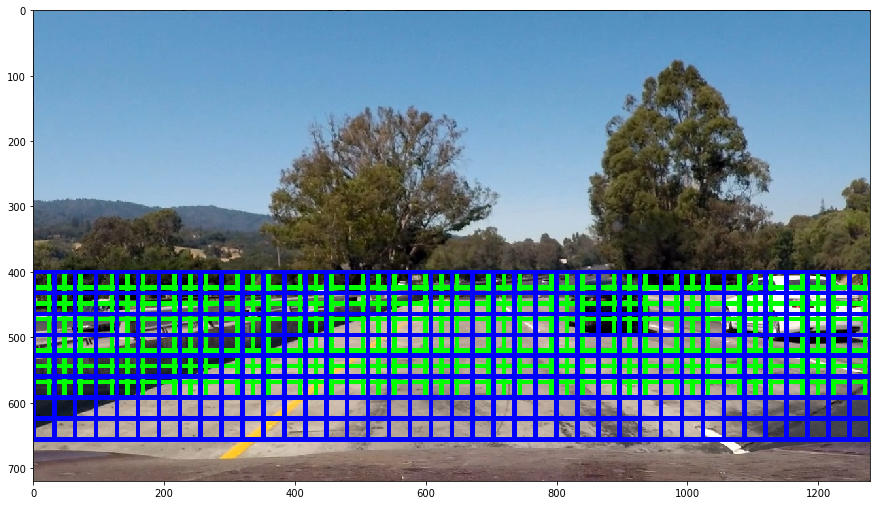

In [11]:
# Visualize sliding window search
# Confine to where the vehicles are likely to show up
ystart = 400
ystops = [592, 656]
xstart = 0
xstop = 1280
pix_per_cell = 8 
cell_per_block = 2
scales = [1.5, 2.0]

def draw_window(img, ystart, ystop, xstart, xstop, scale, pix_per_cell, cell_per_block, color=(0,0,255)):
    
    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1     
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    print('Scale:', scale, ' No. of Windows:', nxsteps*nysteps)

    for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)                                 
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),
                              (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),
                              color,6)
    return draw_img

test_img = mpimg.imread('test_images/test1.jpg')
draw_img = draw_window(test_img, ystart, ystops[0], xstart, xstop, scales[0], pix_per_cell, cell_per_block, color=(0,255,0))
draw_img = draw_window(draw_img, ystart, ystops[1], xstart, xstop, scales[1], pix_per_cell, cell_per_block, color=(0,0,255))

plt.figure(figsize=(15,15))
plt.imshow(draw_img)

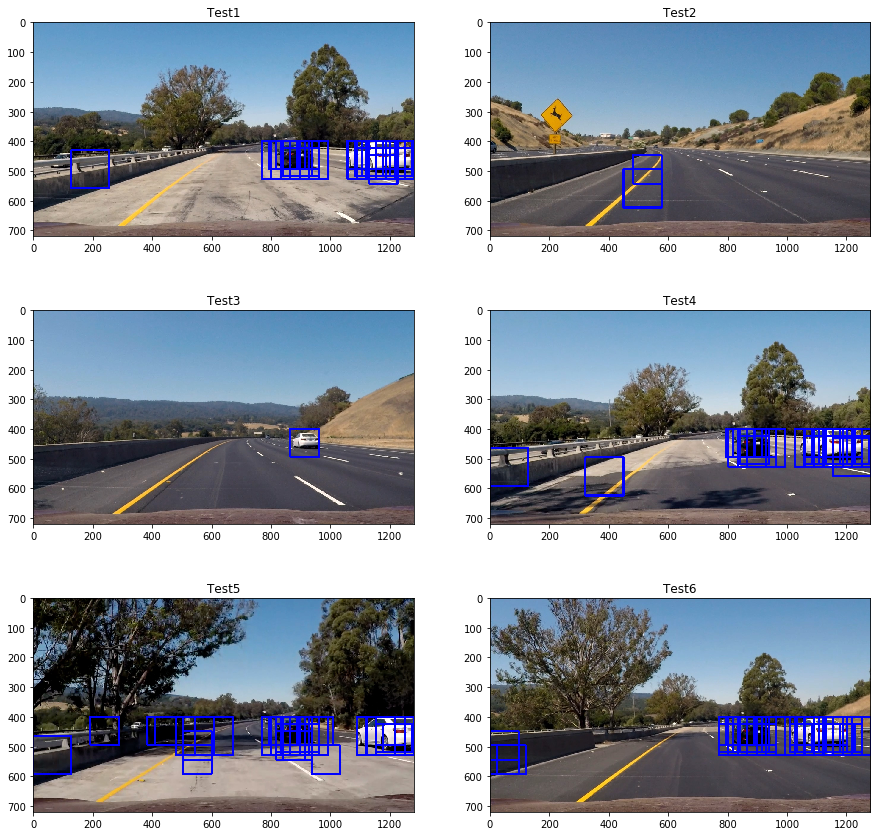

In [12]:
# Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Try on test images
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
test_imgs = glob.glob('test_images/test*.jpg')

ystart = 400
ystops = [592, 656]
xstart = 0
xstop = 1280
scales = [1.5, 2.0]

for i in range(len(test_imgs)):
    test_img = mpimg.imread(test_imgs[i])
    bbox_list = []
    for idx in range(2):
        new_list = find_cars(test_img, ystart, ystops[idx], xstart, xstop, scales[idx], svc, X_scaler, 
                             orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, hog_channel, vis=False)
        bbox_list.extend(new_list)

    draw_img = np.copy(test_img)
    for bbox in bbox_list:
        cv2.rectangle(draw_img, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), (0,0,255), 6)

    ax[i//2][i%2].imshow(draw_img)
    ax[i//2][i%2].set_title('Test%d' % (i+1))
    

## Filter out false positive detection

In [13]:
from scipy.ndimage.measurements import label

# Add heat from boundary list obtained from detection
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [14]:
# Apply threshold to filter out unwanted ones
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [15]:
# Draw on original image with labels
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Reject objects with dimensions too small
        if bbox[1][0]-bbox[0][0] < 50 or bbox[1][1]-bbox[0][1] < 50:
            continue
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Test on 6 consecutive frames from test video

In [16]:
# Extract 6 consecutive frames from video
vidcap = cv2.VideoCapture('test_video.mp4')
count = 1
while count < 7:
    success, image = vidcap.read()
    cv2.imwrite('test_images/frame%d.jpg' % count, image)     # save frame as JPEG file    
    count += 1

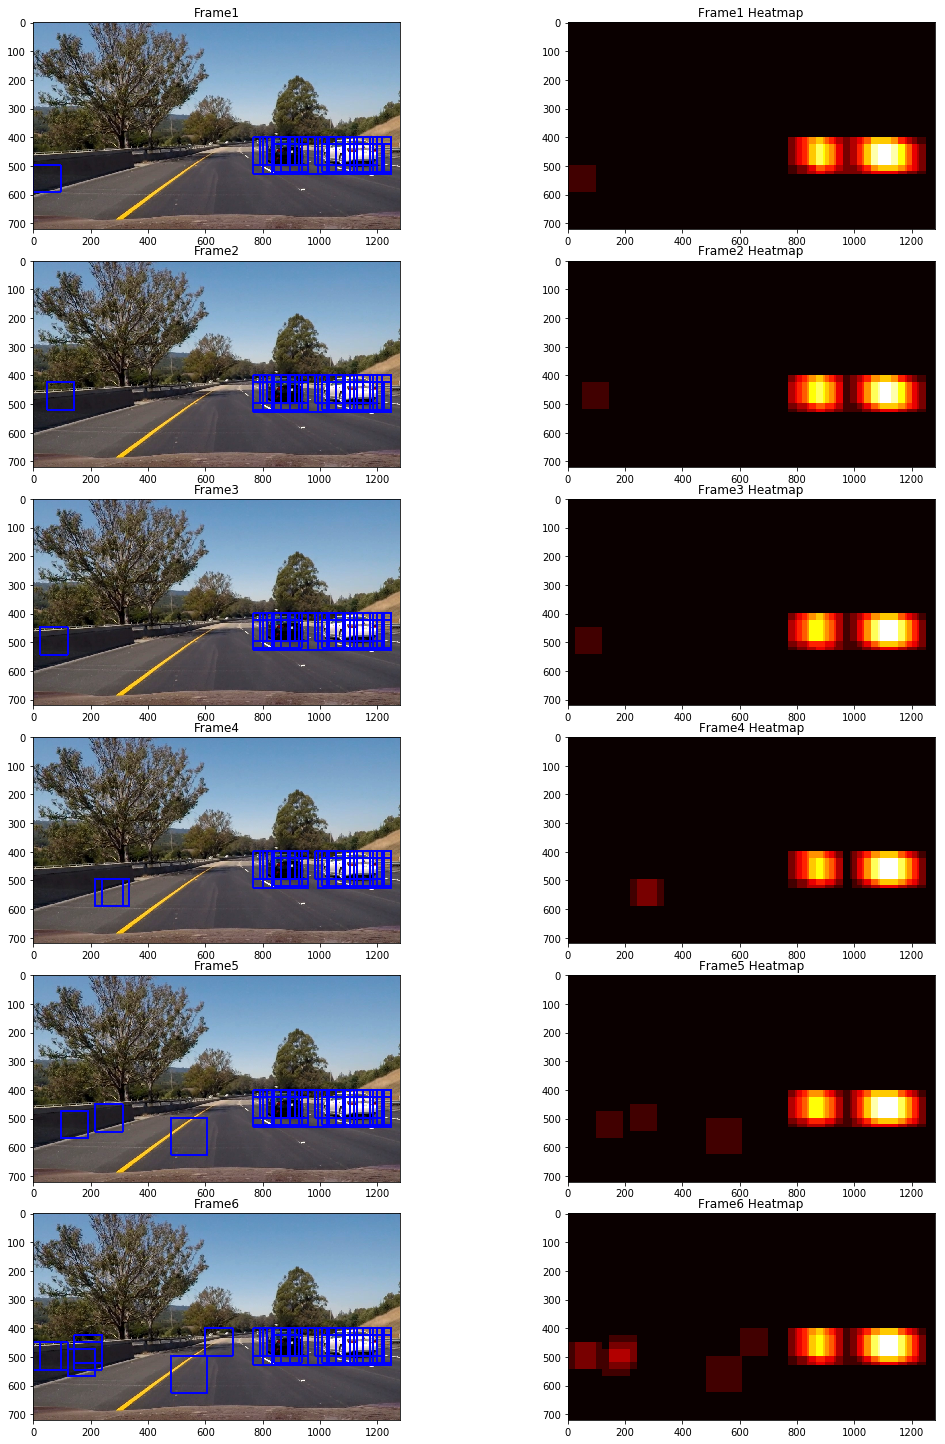

In [17]:
# Generate heatmaps for 6 consecutive frames
frames = glob.glob('test_images/frame*.jpg')
fig, ax = plt.subplots(6, 2, figsize=(15, 20))
fig.tight_layout()

# Parameters for feature extraction
ystart = 400
ystops = [592, 656]
xstart = 0
xstop = 1280
scales = [1.5, 2.0]

heats = [] # for use in next cell
for i, frame in enumerate(frames):    
    img = mpimg.imread(frame)   
    bbox_list = []
    for j in range(2):
        new_list = find_cars(img, ystart, ystops[j], xstart, xstop, scales[j], svc, X_scaler, 
                             orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, hog_channel, vis=False)
        bbox_list.extend(new_list)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)     
    heat = add_heat(heat, bbox_list)    
    heats.append(heat)
    heatmap = np.clip(heat, 0, 255)
    
    draw_img = np.copy(test_img)
    for bbox in bbox_list:
        cv2.rectangle(draw_img, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), (0,0,255), 6)
    
    ax[i][0].set_title('Frame%d' % (i+1))
    ax[i][0].imshow(draw_img)
    ax[i][1].set_title('Frame%d Heatmap' % (i+1))
    ax[i][1].imshow(heatmap, cmap='hot')    

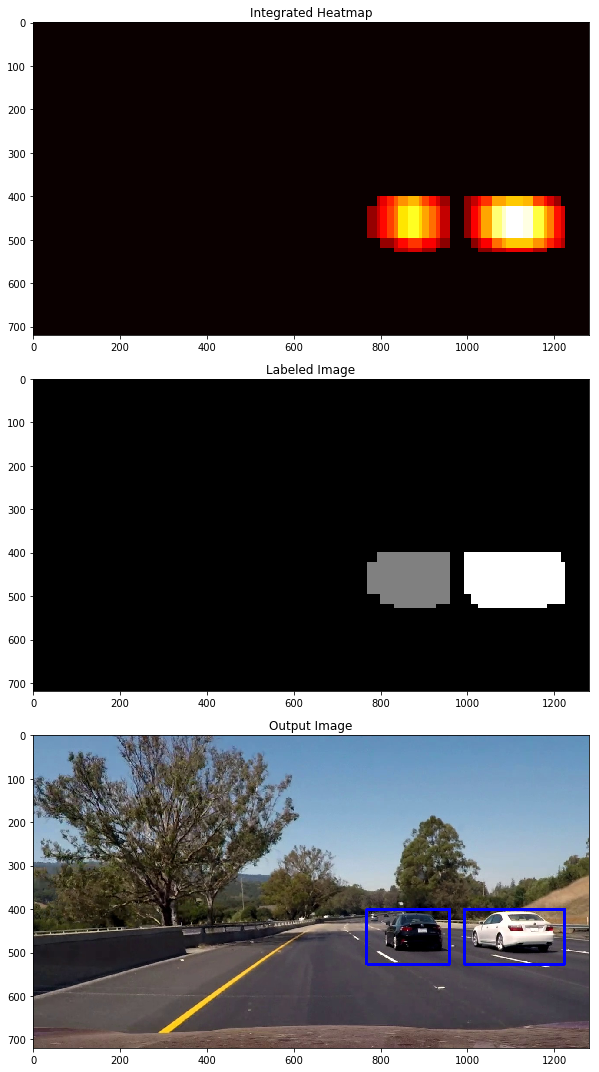

In [18]:
# Integrate heatmaps over 6 frames
intgrated_heatmap = np.zeros_like(heats[0])
for heat in heats:
    intgrated_heatmap += heat

# Find final boxes from heatmaps using label function
intgrated_heatmap = apply_threshold(intgrated_heatmap, 2*len(heats))
intgrated_heatmap = np.clip(intgrated_heatmap, 0, 255)
labels = label(intgrated_heatmap)
img = mpimg.imread(frames[-1])
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(15,15))
plt.subplot(311)
plt.imshow(intgrated_heatmap, cmap='hot')
plt.title('Integrated Heatmap')
plt.subplot(312)
plt.imshow(labels[0], cmap='gray')
plt.title('Labeled Image')
plt.subplot(313)
plt.imshow(draw_img)
plt.title('Output Image')
fig.tight_layout()

## Image processing pipeline

In [19]:
import collections

# Define a class to keep tracks on detected vehicles
class Vehicle():    
    def __init__(self):
        global id_counter
        self.n = 10 # last n times this vehicle has been detected
        self.n_miss = 0 # number of consecutive missed detection
        self.id = id_counter # id for this car
        self.bboxes = collections.deque(maxlen=self.n) # bbox for last n detection 
        self.best_bbox = None # average bbox for last n detection 
        self.matched = False # if matched with new detection
        self.visible = False # if visible on current frame   
        id_counter += 1
        
    def update(self, bbox):
        self.n_miss = 0
        self.matched = True
        self.visible = True
        self.bboxes.append(bbox)
        self.best_bbox = np.mean(self.bboxes, axis=0).astype(np.int)
        
# Define a class to keep tracks on integrated heatmap over frames
class Heatmap():
    def __init__(self):
        self.n = 6 # integrate over last n frames
        self.heats = collections.deque(maxlen=self.n) # heatmaps for last n detection
        self.heatmap = None # filtered heatmap over last n detection for output
    
    def update(self, img, bbox_list):
        if len(bbox_list) > 0: # add new detections
            self.heats.append(bbox_list)
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat, np.concatenate(self.heats))
        heat = apply_threshold(heat, 2*len(self.heats))
        self.heatmap = np.clip(heat, 0, 255)

In [20]:
# Define more helper functions

# Get carlist from given labels
def get_carslist(labels):
    carslist = []
    for car_number in range(1, labels[1]+1):        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Reject bbox that is too small
        if ((bbox[1][0]-bbox[0][0]) * (bbox[1][1]-bbox[0][1])) > 1000:
            carslist.append(bbox)
    return carslist

# Get distance between to bbox
def get_distance(bbox, other_bbox):
    d = np.sqrt((np.average((bbox[0][0], bbox[1][0])) - np.average((other_bbox[0][0], other_bbox[1][0])))**2 + 
                (np.average((bbox[0][1], bbox[1][1])) - np.average((other_bbox[0][1], other_bbox[1][1])))**2)
    return d

# Draw bboxes on image
def draw_bboxes(img, bboxes):
    # Iterate through all detected cars
    for bbox in bboxes:     
        # Draw the box on the image
        cv2.rectangle(img, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), (0,0,255), 6)
    # Return the image
    return img

In [21]:
# Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [22]:
def process_image(img):
    global detected_carslist, integrated_heatmap, frame_counter
        
    # If no previous detected car, do detection on every 10 frames
    if len(detected_carslist) == 0 and (frame_counter % 10) != 0:
        frame_counter += 1
        return img
    
    # Only do full window search with 2 scales on first frame and every 10 frames after
    bbox_list = []    
    if (frame_counter % 10) == 0:
        ystart = 400
        ystops = [592, 656]
        xstart = 0
        xstop = img.shape[1]
        scales = [1.5, 2.0]                
        for i in range(len(scales)):
            new_bbox = find_cars(img, ystart, ystops[i], xstart, xstop, scales[i], svc, X_scaler, 
                                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, hog_channel, vis=False) 
            bbox_list.extend(new_bbox)
    
    # Otherwise only search nearby area for previously detected cars
    else: 
        for car in detected_carslist:
            # Search in 105% area of the previous bbox
            ystart = np.max((400, np.int(car.best_bbox[0][1]*0.95)))
            ystop = np.min((656, np.int(car.best_bbox[1][1]*1.05)))
            xstart = np.max((0, np.int(car.best_bbox[0][0]*0.95)))
            xstop = np.min((img.shape[1], np.int(car.best_bbox[1][0]*1.05)))
            factor = (car.best_bbox[1][1]-car.best_bbox[0][1])/128
            scales = [1.5*factor, 2.0*factor]            
            for i in range(len(scales)):
                new_bbox = find_cars(img, ystart, ystop, xstart, xstop, scales[i], svc, X_scaler, 
                                     orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, hog_channel, vis=False) 
                bbox_list.extend(new_bbox)            
            
    frame_counter += 1
    # Find current_carslist in with detected bbox_list
    current_carslist = []
    integrated_heatmap.update(img, bbox_list)
    labels = label(integrated_heatmap.heatmap)
    current_carslist = get_carslist(labels)
    
    # Turn detected cars invisible and not matched yet by defult
    for car in detected_carslist:
        car.matched = False
        car.visible = False  
            
    # Update detected_carslist
    # Try to match current carslist with previously detected cars
    for bbox in current_carslist:
        match_idx = None
        min_d = 100
        for i in range(len(detected_carslist)):
            d = get_distance(bbox, detected_carslist[i].best_bbox)
            if d < min_d:
                min_d = d
                match_idx = i
        if match_idx != None: # found existing car
            detected_carslist[match_idx].update(bbox)            
            
        else: # found new car
            new_car = Vehicle()
            new_car.update(bbox)
            detected_carslist.append(new_car)
                
    # Draw images with all visible cars
    best_bboxes = []
    for car in detected_carslist:
        if car.matched == False: # if no match, record number of consecutive missed frame
            car.n_miss += 1
        if car.n_miss <= 5: # if missed 5 or less frames, still show
            car.visible = True
        else:
            detected_carslist.remove(car) # if missed more than 5 consecutive frames, remove this car            
        if car.visible == True: # draw all visible cars
            best_bboxes.append(car.best_bbox)
    # Output image
    draw_img = draw_bboxes(np.copy(img), best_bboxes)    
    return draw_img

### Try on test image

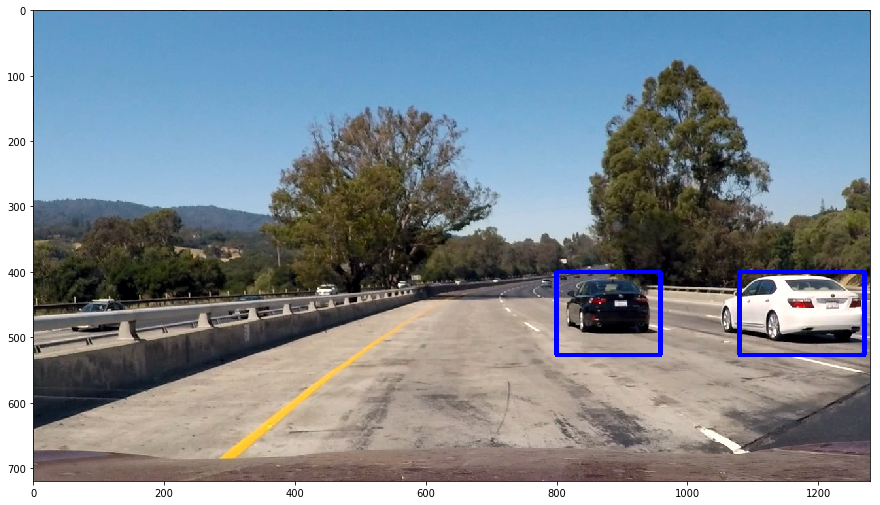

In [23]:
img = mpimg.imread('test_images/test1.jpg')
detected_carslist = []
integrated_heatmap = Heatmap()
frame_counter = 0
id_counter = 1
draw_img = process_image(img)

plt.figure(figsize=(15,15))
plt.imshow(draw_img)

## Try on test video

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
# Empty global variables
detected_carslist = []
integrated_heatmap = Heatmap()
frame_counter = 0
id_counter = 1

In [26]:
test_output = 'output_videos/test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
test_clip = clip1.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|████████████████████████████████████████████████████████████▍ | 38/39 [00:08<00:00,  4.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

Wall time: 10.6 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

## Project video

In [28]:
# Empty global variables again
detected_carslist = []
integrated_heatmap = Heatmap()
frame_counter = 0
id_counter = 1

In [29]:
project_output = 'output_videos/project_video.mp4'
clip2 = VideoFileClip("project_video.mp4")#.subclip(20,25)
project_clip = clip2.fl_image(process_image)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████▉| 1260/1261 [04:06<00:00,  2.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 4min 7s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))